In [1]:
%%capture
import os
import requests
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import math
import nltk
from nltk.translate import gleu_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import fbeta_score, precision_score, recall_score
from tensorflow.keras.preprocessing.sequence import pad_sequences


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts
import torch.utils.checkpoint as checkpoint

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AdamW
import matplotlib.pyplot as plt

2024-11-30 02:46:25.689126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732916785.757312   59058 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732916785.775916   59058 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 02:46:25.889331: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def create_dataset(incorrect_file, correct_file):
    # Read both files
    with open(incorrect_file, 'r', encoding='utf-8') as file:
        incorrect_lines = file.readlines()

    with open(correct_file, 'r', encoding='utf-8') as file:
        correct_lines = file.readlines()

    # Ensure both files have the same number of lines
    if len(incorrect_lines) != len(correct_lines):
        raise ValueError("The number of lines in the incorrect and correct files do not match.")

    # Create the dataset
    dataset = []
    for i in range(len(incorrect_lines)):
        input_text = "جملے کی درستگی: " + incorrect_lines[i].strip()
        output_text = correct_lines[i].strip()

        dataset.append({"input": input_text, "output": output_text})

    return dataset
dataset = create_dataset('/home/aa07600/Documents/urdu GEC/ipynbFiles/data/sampled_augmented_incorrect.txt', '/home/aa07600/Documents/urdu GEC/ipynbFiles/data/sampled_augmented_correct.txt')
dataset[:4]

[{'input': 'جملے کی درستگی: نہیں نوید ان میں سے کوئی بھی لطیفہ میں ے پوسٹ نہیں کیا اس لئیے آئے اور اپنے وطن کے لئیے اپنی قلمی صلاحیت کا مظاہرہ کریں۔',
  'output': 'نہیں نوید ان میں سے کوئی بھی لطیفہ میں ے پوسٹ نہیں کیا اس لئیے آئیے اور اپنے وطن کے لئیے اپنی قلمی صلاحیت کا مظاہرہ کریں۔'},
 {'input': 'جملے کی درستگی: انٹرنیٹ اکسپلورر اس کے مقابلے میں بہت تیزی سے چل رہا ہے ۔',
  'output': 'انٹرنیٹ اکسپلورر اس کے مقابلے میں بہت تیزی سے چل رہا ہے ۔'},
 {'input': 'جملے کی درستگی: وہ کا بہتر جو اب تو شاعر صاحب ہی دے سکتے ہیں',
  'output': 'اس کا بہتر جو اب تو شاعر صاحب ہی دے سکتے ہیں'},
 {'input': 'جملے کی درستگی: فیتہ لگانا، جوڑن ا،جز بندی کرنا ،م جلد، انتظام ،سلسلہ سوشل نیٹ ورکنگ سائٹ ٹوئٹر پر امیتابھ کی چاہنے والوں کی تعداد ۷۰ لاکھ سے تجاوز کر چکی ہے۔',
  'output': 'فیتہ لگانا، جوڑن ا،جز بندی کرنا ،م جلد، انتظام ،سلسلہ سوشل نیٹ ورکنگ سائٹ ٹوئٹر پر امیتابھ کے چاہنے والوں کی تعداد ۷۰ لاکھ سے تجاوز کر چکی ہے۔'}]

In [3]:
print(len(dataset))

240163


In [4]:
# Convert dataset to a NumPy array
dataset = np.array(dataset)

# Shuffle the indices
indices = np.arange(len(dataset))
np.random.shuffle(indices)

# Extract the subset using fancy indexing
shuffled_dataset = dataset[indices]

In [6]:
shuffled_dataset.shape

(240163,)

In [7]:
# Calculate the split index
split_index = int(len(shuffled_dataset) * 0.8)

# Split the dataset
train_dataset, test_dataset = shuffled_dataset[:split_index], shuffled_dataset[split_index:]

In [8]:
train_dataset[:2]

array([{'input': 'جملے کی درستگی: ویسے باجو روزانہ کا ایک آدھ پیغام چھو ڑ دیا کریں چاہے جتنی مصروف ہوں ۔', 'output': 'ویسے باجو روزانہ کا ایک آدھ پیغام چھو ڑ دیا کریں چاہے جتنی مصروف ہوں ۔'},
       {'input': 'جملے کی درستگی: خاص طور پہ ان کے افسانہ نگاری کے تعریف کرنا چاہوں گا', 'output': 'خاص طور پہ ان کی افسانہ نگاری کی تعریف کرنا چاہوں گا'}],
      dtype=object)

In [9]:
print(len(train_dataset))
print(len(test_dataset))

192130
48033


In [10]:
checkpoint = "bigscience/mt0-base"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint, torch_dtype="auto", device_map="auto")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
         

In [12]:
# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
#optimizer = optim.SGD(model.parameters(), lr=1e-5)#, momentum=0.9, weight_decay=1e-5)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

batch_size = 4
# Gradient accumulation
accumulation_steps = 4  # Accumulate gradients over 4 batches before updating

# Gradient clipping
max_grad_norm = 1.0  # Set your desired maximum gradient norm

# Mixed-precision training
scaler = GradScaler()

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt").to(device)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}


def train(train_dataloader):
    global model
    global optimizer
    global scheduler

    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        inputs = batch[0]["input_ids"]
        labels = batch[1]["input_ids"]

        optimizer.zero_grad()

        outputs = model(inputs, labels=labels)
        logits = outputs.logits

        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)


        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=-1)
        correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
        total_train_samples += labels.numel()

    return total_train_samples, total_loss, correct_train_predictions


def train_mixed_precision(train_dataloader):
    global model
    global optimizer
    global scheduler
    global scaler
    global accumulation_steps
    global max_grad_norm

    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        inputs = batch[0]["input_ids"]
        labels = batch[1]["input_ids"]

        max_length = max(inputs.size(1), labels.size(1))
        inputs = F.pad(inputs, (0, max_length - inputs.size(1)))
        labels = F.pad(labels, (0, max_length - labels.size(1)))

        with autocast():  # Use mixed-precision training
            optimizer.zero_grad()
            outputs = model(inputs, labels=labels)
            logits = outputs.logits

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=-1)
        correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
        total_train_samples += labels.numel()

    return total_train_samples, total_loss, correct_train_predictions

def train_checkpoint(train_dataloader):
    global model
    global optimizer
    global scheduler

    total_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        inputs = batch[0]["input_ids"]
        labels = batch[1]["input_ids"]

        optimizer.zero_grad()
        # Define the function that computes the forward pass
        def forward_pass(inputs, labels):
            outputs = model(inputs, labels=labels)
            logits = outputs.logits
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1), ignore_index=tokenizer.pad_token_id)
            return logits, loss

        # Use gradient checkpointing for the forward pass
        logits, loss = checkpoint.checkpoint(forward_pass, inputs, labels, use_reentrant=False)
        #loss.requires_grad = True
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=-1)
        correct_train_predictions += torch.sum(predicted_labels.view(-1) == labels.view(-1)).item()
        total_train_samples += labels.numel()

    return total_train_samples, total_loss, correct_train_predictions

def validate(validation_dataloader):
    global model

    total_samples = 0
    val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for val_batch in validation_dataloader:
            val_inputs = val_batch[0]["input_ids"]
            val_labels = val_batch[1]["input_ids"]

            val_outputs = model(val_inputs, labels=val_labels)
            val_logits = val_outputs.logits

            val_loss += F.cross_entropy(val_logits.view(-1, val_logits.size(-1)), val_labels.view(-1), ignore_index=tokenizer.pad_token_id).item()

            _, predicted_labels = torch.max(val_logits, dim=-1)
            correct_predictions += torch.sum(predicted_labels.view(-1) == val_labels.view(-1)).item()
            total_samples += val_labels.numel()

    return total_samples, val_loss, correct_predictions


def initialize_data(start, end):
    global train_dataset

    input_texts = [example["input"] for example in train_dataset[start:end]]
    target_texts = [example["output"] for example in train_dataset[start:end]]

    # train validation split
    split_ratio = 0.9
    train_size = int(split_ratio * len(input_texts))
    indices = np.arange(len(input_texts))
    np.random.shuffle(indices)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_input_texts = [input_texts[i] for i in train_indices]
    train_target_texts = [target_texts[i] for i in train_indices]
    validation_input_texts = [input_texts[i] for i in val_indices]
    validation_target_texts = [target_texts[i] for i in val_indices]

    # custom datasets
    train_input_dataset = CustomDataset(train_input_texts, tokenizer)
    train_target_dataset = CustomDataset(train_target_texts, tokenizer)
    validation_input_dataset = CustomDataset(validation_input_texts, tokenizer)
    validation_target_dataset = CustomDataset(validation_target_texts, tokenizer)

    # Combine datasets for DataLoader
    train_combined_dataset = list(zip(train_input_dataset, train_target_dataset))
    train_dataloader = DataLoader(train_combined_dataset, batch_size=batch_size, shuffle=True)
    validation_combined_dataset = list(zip(validation_input_dataset, validation_target_dataset))
    validation_dataloader = DataLoader(validation_combined_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, validation_dataloader


# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# num_epochs = 100 #This was 100 epochs taken from last years work, we are currently doing 5
num_epochs = 4
start_index = 0
end_index = len(train_dataset) #This was supposed to be the entire length of dataset but for debugging its 1000
# end_index = 100
train_dataloader, validation_dataloader = initialize_data(start_index, end_index)

for epoch in range(num_epochs):
    total_train_samples, total_loss, correct_train_predictions = train(train_dataloader)
    scheduler.step()

    #validation
    total_samples, val_loss, correct_predictions = validate(validation_dataloader)

    # Metrics
    average_train_loss = total_loss / len(train_dataloader)
    average_val_loss = val_loss / len(validation_dataloader)

    accuracy = correct_predictions / total_samples
    accuracy_train = correct_train_predictions / total_train_samples

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    val_accuracies.append(accuracy)
    train_accuracies.append(accuracy_train)

    print(f"Train Loss: {average_train_loss}, Train accuracy: {accuracy_train}, Val Loss: {average_val_loss}, Val Accuracy: {accuracy}")

    name = f"./finetuned_mt0_base_synthetic_dataset_{epoch + 1}"
    model.save_pretrained(name)
    tokenizer.save_pretrained(name)
    print("Saved as ", name)

/tmp/ipykernel_666881/509779764.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1: 100%|██████████| 43230/43230 [2:33:21<00:00,  4.70it/s]  


Train Loss: 0.03335710656542962, Train accuracy: 0.310625161979566, Val Loss: 0.01632865141201863, Val Accuracy: 0.31072496553826046
Saved as  ./finetuned_mt0_base_synthetic_dataset_1


Epoch 2: 100%|██████████| 43230/43230 [2:33:28<00:00,  4.69it/s]  


Train Loss: 0.010792820572425386, Train accuracy: 0.31234239131115227, Val Loss: 0.011420647869961342, Val Accuracy: 0.31119017890056183
Saved as  ./finetuned_mt0_base_synthetic_dataset_2


Epoch 3: 100%|██████████| 43230/43230 [2:36:59<00:00,  4.59it/s]  


Train Loss: 0.0070144383827543, Train accuracy: 0.3126363169648939, Val Loss: 0.008047322760727782, Val Accuracy: 0.3114327122797547
Saved as  ./finetuned_mt0_base_synthetic_dataset_3


Epoch 4: 100%|██████████| 43230/43230 [2:33:22<00:00,  4.70it/s]  


Train Loss: 0.005253041798421037, Train accuracy: 0.31278381637003727, Val Loss: 0.007446798976795173, Val Accuracy: 0.3114756385415588
Saved as  ./finetuned_mt0_base_synthetic_dataset_4


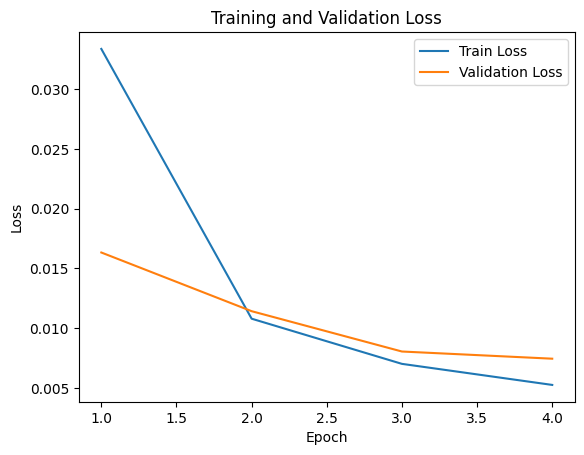

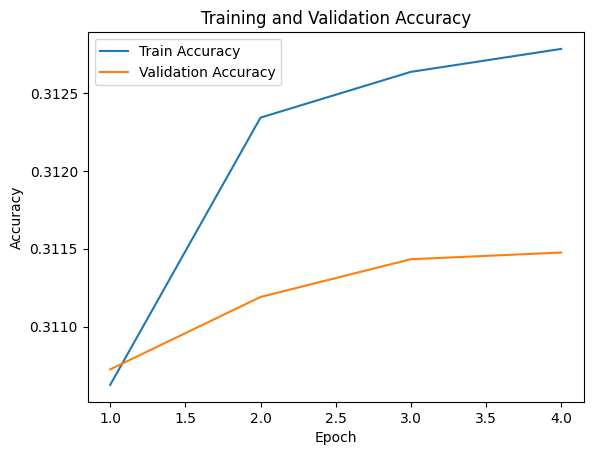

In [13]:
# Loss Plot
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Accuracy Plot
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [14]:
torch.cuda.empty_cache()
optimizer.zero_grad()
torch.no_grad()

In [2]:
model_path = "./finetuned_mt0_base_synthetic_dataset_4"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path, torch_dtype="auto", device_map="auto")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Fine-tuned model and tokenizer loaded successfully!")

Fine-tuned model and tokenizer loaded successfully!


In [6]:
def pad_sequences_to_max_length(sequences, max_length, padding_value):
    return pad_sequences(sequences, maxlen=max_length, padding='post', value=padding_value, dtype=object)

def calculate_gleu_score(reference, hypothesis):

    reference_tokens = []
    hypothesis_tokens = []
    for i in range(len(reference)):
        reference_sentence_token_list = nltk.word_tokenize(reference[i])
        hypothesis_sentence_token_list = nltk.word_tokenize(hypothesis[i])
        reference_tokens.append([reference_sentence_token_list])
        hypothesis_tokens.append(hypothesis_sentence_token_list)

    # Calculate GLEU score
    gleu = gleu_score.corpus_gleu(reference_tokens, hypothesis_tokens)
    return gleu

def calculate_f05_score(reference, hypothesis):
    # Tokenize sentences into words
    reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
    hypothesis_tokens = [nltk.word_tokenize(sent) for sent in hypothesis]

    max_length = max(max(len(tokens) for tokens in reference_tokens),
                    max(len(tokens) for tokens in hypothesis_tokens))

    # Pad sequences to the maximum length
    reference_padded = pad_sequences_to_max_length(reference_tokens, max_length, '<PAD>')
    hypothesis_padded = pad_sequences_to_max_length(hypothesis_tokens, max_length, '<PAD>')

    # Flatten the lists to get a list of all tokens
    reference_tokens_flat = [token for sent in reference_padded for token in sent]
    hypothesis_tokens_flat = [token for sent in hypothesis_padded for token in sent]

    # Convert tokens to lists for F0.5 calculation
    reference_list = list(reference_tokens_flat)
    hypothesis_list = list(hypothesis_tokens_flat)

    # Calculate F0.5 score
    f05 = fbeta_score(reference_list, hypothesis_list, beta=0.5, average='macro')

    return f05

def calculate_precision_recall(reference, hypothesis):
    # Tokenize sentences into words
    reference_tokens = [nltk.word_tokenize(sent) for sent in reference]
    hypothesis_tokens = [nltk.word_tokenize(sent) for sent in hypothesis]

    max_length = max(max(len(tokens) for tokens in reference_tokens),
                    max(len(tokens) for tokens in hypothesis_tokens))

    # Pad sequences to the maximum length
    reference_padded = pad_sequences_to_max_length(reference_tokens, max_length, '<PAD>')
    hypothesis_padded = pad_sequences_to_max_length(hypothesis_tokens, max_length, '<PAD>')

    # Flatten the lists to get a list of all tokens
    reference_tokens_flat = [token for sent in reference_padded for token in sent]
    hypothesis_tokens_flat = [token for sent in hypothesis_padded for token in sent]

    # Convert tokens to lists
    reference_list = list(reference_tokens_flat)
    hypothesis_list = list(hypothesis_tokens_flat)

    # Calculate precision and recall
    precision = precision_score(reference_list, hypothesis_list, average='macro', zero_division=1)
    recall = recall_score(reference_list, hypothesis_list, average='macro', zero_division=1)

    return precision, recall

In [7]:
def generate_sentences(test_dataset):
    """
    Generates predicted sentences and returns sets of incorrect,
    correct, and predicted sentences.
    """
    incorrect_sentences = []
    correct_sentences = []
    predicted_sentences = []

    for i in tqdm(range(len(test_dataset)), desc="Processing test data"):
    # for i in tqdm(range(10), desc="Processing test data"):
        incorrect_sentence = test_dataset[i]["input"]
        incorrect_sentences.append(incorrect_sentence)
        correct_sentences.append(test_dataset[i]["output"])

        input_ids = tokenizer.encode(incorrect_sentence, return_tensors="pt", max_length=128, truncation=True).to(device)
        output_ids = model.generate(input_ids, max_length=128, num_beams=1, num_return_sequences=1)
        predicted_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predicted_sentences.append(predicted_sentence)
    return incorrect_sentences, correct_sentences, predicted_sentences

def compute_scores(correct_sentences, predicted_sentences, scores_file_name):
    """
    Computes evaluation metrics and writes results to a file.
    """
    # Calculate metrics
    total_gleu_score = calculate_gleu_score(correct_sentences, predicted_sentences)
    total_f05_score = calculate_f05_score(correct_sentences, predicted_sentences)
    total_precision, total_recall = calculate_precision_recall(correct_sentences, predicted_sentences)

    # Write results to the scores file
    with open(scores_file_name, 'w', encoding='utf-8') as scores_file:
        scores_file.write("Results for test data\n")
        scores_file.write(f"GLEU Score: {total_gleu_score}\n")
        scores_file.write(f"F0.5 Score: {total_f05_score}\n")
        scores_file.write(f"Precision: {total_precision}\n")
        scores_file.write(f"Recall: {total_recall}\n\n")

In [20]:
# Generate sentence sets
incorrect, correct, predicted = generate_sentences(test_dataset[:2000])

Processing test data: 100%|██████████| 2000/2000 [13:56<00:00,  2.39it/s]


In [21]:
# Compute scores using the correct and predicted sentences
compute_scores(correct, predicted, "scores.txt")

In [22]:
# Print the contents of scores.txt
with open("scores.txt", "r", encoding="utf-8") as file:
    content = file.read()
    print(content)

Results for test data
GLEU Score: 0.9853323295854683
F0.5 Score: 0.9858828892076569
Precision: 0.9902556945433592
Recall: 0.992414742019716




In [23]:

def read_file(file_path):
    """Reads a file and returns its content as a list of lines."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

gold_src_data = read_file('/home/aa07600/Documents/urdu GEC/ipynbFiles/data/gold/gold_src.txt')
gold_trg_data = read_file('/home/aa07600/Documents/urdu GEC/ipynbFiles/data/gold/gold_trg.txt')

In [24]:
def generate_sentences_gold(gold_src_data, gold_trg_data):
    """
    Generates predicted sentences and returns sets of incorrect,
    correct, and predicted sentences.
    """
    incorrect_sentences = []
    correct_sentences = []
    predicted_sentences = []

    for i in tqdm(range(len(gold_src_data)), desc="Processing gold data"):
    # for i in tqdm(range(10), desc="Processing gold data"):
        input_text = "جملے کی درستگی: " + gold_src_data[i].strip()
        incorrect_sentence = gold_src_data[i].strip()
        correct_sentence = gold_trg_data[i].strip()

        incorrect_sentences.append(incorrect_sentence)
        correct_sentences.append(correct_sentence)

        input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
        output_ids = model.generate(input_ids, max_length=128, num_beams=1, num_return_sequences=1)
        predicted_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predicted_sentences.append(predicted_sentence)
    return incorrect_sentences, correct_sentences, predicted_sentences

def compute_scores_gold(correct_sentences, predicted_sentences, scores_file_name):
    """
    Computes evaluation metrics and writes results to a file.
    """
    # Calculate metrics
    total_gleu_score = calculate_gleu_score(correct_sentences, predicted_sentences)
    total_f05_score = calculate_f05_score(correct_sentences, predicted_sentences)
    total_precision, total_recall = calculate_precision_recall(correct_sentences, predicted_sentences)

    # Write results to the scores file
    with open(scores_file_name, 'w', encoding='utf-8') as scores_file:
        scores_file.write("Results for gold data\n")
        scores_file.write(f"GLEU Score: {total_gleu_score}\n")
        scores_file.write(f"F0.5 Score: {total_f05_score}\n")
        scores_file.write(f"Precision: {total_precision}\n")
        scores_file.write(f"Recall: {total_recall}\n\n")

# Generate sentence sets
incorrect_gold, correct_gold, predicted_gold = generate_sentences_gold(gold_src_data, gold_trg_data)

# Compute scores using the correct and predicted sentences
compute_scores_gold(correct_gold, predicted_gold, "scores_gold.txt")

Processing gold data: 100%|██████████| 1204/1204 [05:08<00:00,  3.91it/s]


In [25]:
# Print the contents of scores.txt
with open("scores_gold.txt", "r", encoding="utf-8") as file:
    content = file.read()
    print(content)

Results for gold data
GLEU Score: 0.7494569152787834
F0.5 Score: 0.6371443939144963
Precision: 0.7313611677253138
Recall: 0.7715424279569536




In [26]:
torch.cuda.empty_cache()
optimizer.zero_grad()
torch.no_grad()

In [27]:
model_path = "./finetuned_mt0_base_synthetic_dataset_3"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path, torch_dtype="auto", device_map="auto")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Fine-tuned model and tokenizer loaded successfully!")

Fine-tuned model and tokenizer loaded successfully!


In [28]:
def generate_sentences_gold(gold_src_data, gold_trg_data):
    """
    Generates predicted sentences and returns sets of incorrect,
    correct, and predicted sentences.
    """
    incorrect_sentences = []
    correct_sentences = []
    predicted_sentences = []

    for i in tqdm(range(len(gold_src_data)), desc="Processing gold data"):
    # for i in tqdm(range(10), desc="Processing gold data"):
        input_text = "جملے کی درستگی: " + gold_src_data[i].strip()
        incorrect_sentence = gold_src_data[i].strip()
        correct_sentence = gold_trg_data[i].strip()

        incorrect_sentences.append(incorrect_sentence)
        correct_sentences.append(correct_sentence)

        input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
        output_ids = model.generate(input_ids, max_length=128, num_beams=1, num_return_sequences=1)
        predicted_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predicted_sentences.append(predicted_sentence)
    return incorrect_sentences, correct_sentences, predicted_sentences

def compute_scores_gold(correct_sentences, predicted_sentences, scores_file_name):
    """
    Computes evaluation metrics and writes results to a file.
    """
    # Calculate metrics
    total_gleu_score = calculate_gleu_score(correct_sentences, predicted_sentences)
    total_f05_score = calculate_f05_score(correct_sentences, predicted_sentences)
    total_precision, total_recall = calculate_precision_recall(correct_sentences, predicted_sentences)

    # Write results to the scores file
    with open(scores_file_name, 'w', encoding='utf-8') as scores_file:
        scores_file.write("Results for gold data\n")
        scores_file.write(f"GLEU Score: {total_gleu_score}\n")
        scores_file.write(f"F0.5 Score: {total_f05_score}\n")
        scores_file.write(f"Precision: {total_precision}\n")
        scores_file.write(f"Recall: {total_recall}\n\n")

# Generate sentence sets
incorrect_gold, correct_gold, predicted_gold = generate_sentences_gold(gold_src_data, gold_trg_data)

# Compute scores using the correct and predicted sentences
compute_scores_gold(correct_gold, predicted_gold, "scores_gold_epoch3.txt")

Processing gold data: 100%|██████████| 1204/1204 [05:21<00:00,  3.74it/s]


In [29]:
# Print the contents of scores.txt
with open("scores_gold_epoch3.txt", "r", encoding="utf-8") as file:
    content = file.read()
    print(content)

Results for gold data
GLEU Score: 0.7161438779217634
F0.5 Score: 0.6180152668875203
Precision: 0.7202294460986467
Recall: 0.7581535188140887




In [30]:
torch.cuda.empty_cache()
optimizer.zero_grad()
torch.no_grad()

In [31]:
model_path = "./finetuned_mt0_base_synthetic_dataset_2"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path, torch_dtype="auto", device_map="auto")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Fine-tuned model and tokenizer loaded successfully!")

Fine-tuned model and tokenizer loaded successfully!


In [32]:
def generate_sentences_gold(gold_src_data, gold_trg_data):
    """
    Generates predicted sentences and returns sets of incorrect,
    correct, and predicted sentences.
    """
    incorrect_sentences = []
    correct_sentences = []
    predicted_sentences = []

    for i in tqdm(range(len(gold_src_data)), desc="Processing gold data"):
    # for i in tqdm(range(10), desc="Processing gold data"):
        input_text = "جملے کی درستگی: " + gold_src_data[i].strip()
        incorrect_sentence = gold_src_data[i].strip()
        correct_sentence = gold_trg_data[i].strip()

        incorrect_sentences.append(incorrect_sentence)
        correct_sentences.append(correct_sentence)

        input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
        output_ids = model.generate(input_ids, max_length=128, num_beams=1, num_return_sequences=1)
        predicted_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predicted_sentences.append(predicted_sentence)
    return incorrect_sentences, correct_sentences, predicted_sentences

def compute_scores_gold(correct_sentences, predicted_sentences, scores_file_name):
    """
    Computes evaluation metrics and writes results to a file.
    """
    # Calculate metrics
    total_gleu_score = calculate_gleu_score(correct_sentences, predicted_sentences)
    total_f05_score = calculate_f05_score(correct_sentences, predicted_sentences)
    total_precision, total_recall = calculate_precision_recall(correct_sentences, predicted_sentences)

    # Write results to the scores file
    with open(scores_file_name, 'w', encoding='utf-8') as scores_file:
        scores_file.write("Results for gold data\n")
        scores_file.write(f"GLEU Score: {total_gleu_score}\n")
        scores_file.write(f"F0.5 Score: {total_f05_score}\n")
        scores_file.write(f"Precision: {total_precision}\n")
        scores_file.write(f"Recall: {total_recall}\n\n")

# Generate sentence sets
incorrect_gold, correct_gold, predicted_gold = generate_sentences_gold(gold_src_data, gold_trg_data)

# Compute scores using the correct and predicted sentences
compute_scores_gold(correct_gold, predicted_gold, "scores_gold_epoch2.txt")

Processing gold data: 100%|██████████| 1204/1204 [05:03<00:00,  3.97it/s]


In [33]:
# Print the contents of scores.txt
with open("scores_gold_epoch2.txt", "r", encoding="utf-8") as file:
    content = file.read()
    print(content)

Results for gold data
GLEU Score: 0.7470724248526889
F0.5 Score: 0.638178313748612
Precision: 0.733462614336476
Recall: 0.7670879299027956




In [8]:
'''Computing scores'''
directory_path = "urdu_grammar_correction/data/out_R_filtered" 

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

def compute_scores(directory_path, scores_file_name):
    # Iterate through all subdirectories and files
    for root, dirs, files in os.walk(directory_path):
        for file_name in files:
            # Check if the file is a .src file
            if file_name.endswith(".src"):
                src_file_path = os.path.join(root, file_name)

                # Create the corresponding .trg file path
                trg_file_path = os.path.join(root, file_name.replace(".src", ".trg"))

                # Read data from both .src and .trg files
                src_data = read_file(src_file_path)
                trg_data = read_file(trg_file_path)

                reference_sentences = []
                hypothesis_sentences = []

                for i in tqdm(range(len(src_data)), desc=f"Processing {file_name}"):
                    input_text = "جملے کی درستگی: " + src_data[i].strip()
                    reference_sentences.append(trg_data[i].strip())

                    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=128, truncation=True).to(device)
                    output_ids = model.generate(input_ids, max_length=128, num_beams=1, num_return_sequences=1)                        
                    hypothesis_sentence = tokenizer.decode(output_ids[0], skip_special_tokens=True)
                    hypothesis_sentences.append(hypothesis_sentence)

                total_gleu_score = calculate_gleu_score(reference_sentences, hypothesis_sentences)
                total_f05_score = calculate_f05_score(reference_sentences, hypothesis_sentences)
                total_precision, total_recall = calculate_precision_recall(reference_sentences, hypothesis_sentences)

                with open(scores_file_name, 'a', encoding='utf-8') as scores_file:
                    scores_file.write(f"Error_type: {file_name}\n")
                    scores_file.write(f"GLEU Score: {total_gleu_score}\n")
                    scores_file.write(f"F0.5 Score: {total_f05_score}\n")
                    scores_file.write(f"Precision: {total_precision}\n")
                    scores_file.write(f"Recall: {total_recall}\n\n")

compute_scores(directory_path, "scores_arsalan_data_epoch4.txt")


Processing R_ADP_INFL.src: 100%|██████████| 1461/1461 [09:26<00:00,  2.58it/s]
